# Visualizing RST structures in GeM corpora

This IPython notebook is intended for visualizing discourse structures in multimodal documents, as described using <a href="http://www.sfu.ca/rst/">Rhetorical Structure Theory</a> and annotated using the schema provided by the <a href="http://www.fb10.uni-bremen.de/anglistik/langpro/projects/gem/newframe.html">Genre and Multimodality</a> model.

For visualizing the RST structures, you need the XML files for both base and RST layers. The content is retrieved from the base layer, before drawing out the rhetorical relations between the content segments.

## 1. Import the necessary packages.

In [1]:
# For parsing XML
import xml.etree.ElementTree as et

# For formatting the content
import textwrap
import codecs

# For testing
from IPython.display import Image

Check GraphViz installation.

In [2]:
graphviz_installed = !which dot
if graphviz_installed == '':
    print "Graphviz/DOT not found. Exiting ..."
    quit()
else:
    print "Graphviz/DOT found ..."

Graphviz/DOT found ...


## 2. Parse the GeM XML files.

Define the base and RST files below.

In [3]:
basefile = et.parse('test_xml/2002-she-base-1.xml') # Base layer
rstfile = et.parse('test_xml/2002-she-rst-1.xml') # RST layer

Get the root element for each XML file.

In [4]:
baseroot = basefile.getroot()
rstroot = rstfile.getroot()

Parse the base units.

In [5]:
base_units = {} # Set up an empty dictionary

for unit in baseroot:
    unit_id = unit.attrib['id']
    if 'alt' in unit.attrib:
        unit_content = unit.attrib['alt']
    else:
        unit_content = textwrap.fill(''.join(unit.itertext()), 35)
        
    base_units[unit_id] = unit_content # Populate dictionary with key (id) and value (content) pairs

Parse the RST units.

In [6]:
rst_units = {}

for rstunit in rstroot[0]: # [0] to access the nested <segment> element
    rstunit_id = rstunit.attrib['id']
    rstunit_xref = rstunit.attrib['xref']
    rstunit_content = base_units[rstunit_xref]
    rst_units[rstunit_id] = rstunit_content

Parse the RST relations.

In [7]:
rst_relations = {}

for span in rstroot[1]: # [1] to access the nested <rst-structure> element
    rst_relations[span.attrib['id']] = span.attrib['relation'].upper()

## 3. Draw the RST graph.

Open a file for the graph; use UTF-8 encoding. Set up the beginning and the end of the graph.

In [8]:
graph = codecs.open('graph.gv', 'w', 'utf-8')

begin_graph = 'digraph "rstgraph" { graph [rankdir="BT"];\n'
terminate_graph = '}'

Begin writing the graph.

In [9]:
# Print the DOT graph preamble
# print begin_graph
graph.write(begin_graph)

# Set up a variable that defines the nodes' appearance
node_appearance = ', fontsize="12.0", shape="box", style="filled", color="white"];\n'
span_appearance = ', fontcolor="crimson", fontsize="10.0", shape="plaintext"];\n'

# Add RST spans to the graph
for span in sorted(rst_relations):
    print_span = '"', span, '"\t[label="', rst_relations.get(span), '"', span_appearance
    #print "".join(print_span)
    graph.write("".join(print_span))
    
# Add RST segments to the graph
for node in sorted(rst_units):
    print_node = '"', node, '"\t[label="', rst_units.get(node), '"', node_appearance
    # print "".join(print_node)
    graph.write("".join(print_node))
            
# Add edges
for span in sorted(rstroot[1]):
    if span.tag == 'multi-span':
        multispan, nuclei, relation = span.attrib['id'], span.attrib['nuclei'].split(), span.attrib['relation']
        if span.attrib['id'] == multispan:
            for n in nuclei:
                print_nuclei = '"', n, '" -> ', '"', multispan, '"\t [dir="back"];\n'
                graph.write("".join(print_nuclei))

    if span.tag == 'span':
        spanid, nucleus, satellites, relation = span.attrib['id'], span.attrib['nucleus'].split(), span.attrib['satellites'].split(), span.attrib['relation']
        if span.attrib['id'] == spanid:
            for n in nucleus:
                print_nucleus = '"', n, '" -> ', '"', spanid, '"\t [dir="back"];\n'
                graph.write("".join(print_nucleus))
            for s in satellites:
                print_satellites = '"', s, '" -> ', '"', spanid, '"\t [dir="none"];\n'
                graph.write("".join(print_satellites))
                
    for title in span.iter('title'):
        target_id = span.attrib['id']
        title_xref = title.attrib['xref']
        if span.attrib['id'] == target_id:
            print_title = '"', title_xref, '" -> ', '"', target_id, '"\t [dir="none", style="dashed"];\n'
            graph.write("".join(print_title))

graph.write(terminate_graph)

Close the graph file.

In [10]:
graph.close()

Use DOT draw the graph.

In [11]:
!dot -Tpng graph.gv > graph.png

Show the resulting image in the IPython notebook.

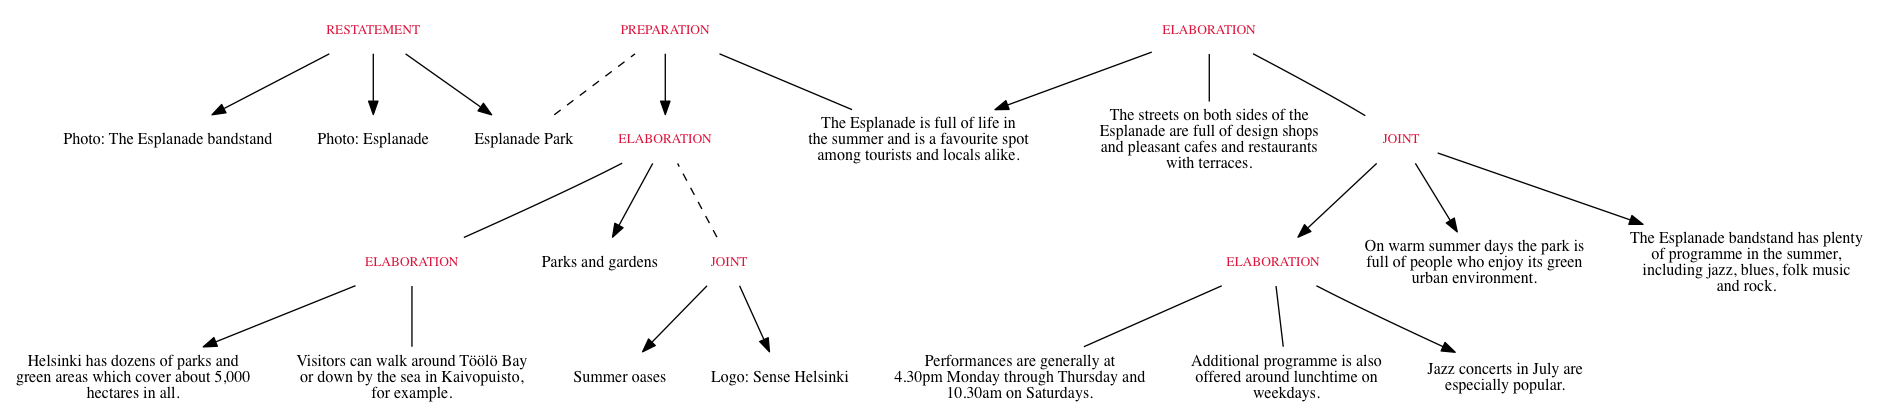

In [12]:
Image('graph.png')